In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import math

In [32]:
import math
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Data Gen

In [36]:
# g : R^2 -> R
# Here, each x \in X are \in R^2
def true_g(X):
    return np.sum(X, axis=1)
    # return np.sum(np.square(X), axis=1)
    # return np.where(np.linalg.norm(X, axis=1) < 4, 0, 1)

# Given g, each x \in X are \in R^3
def true_f(g, X):
    g_result = g(X[:,:2])
    return g_result * (1 - X[:,2]) + (10 * g_result) * X[:,2]

In [37]:
# Number of training points will be split_sizes[0] + split_sizes[1]
def get_train_data(split_sizes):
    n0 = split_sizes[0]
    n1 = split_sizes[1]

    X1_01 = np.around(np.random.uniform(0, 5, size=(n0,2)), 6)
    X1_2 = np.zeros((n0, 1))
    X1 = np.hstack((X1_01, X1_2))

    X2_01 = np.around(np.random.uniform(0, 5, size=(n1,2)), 6)
    X2_2 = np.ones((n1, 1))
    X2 = np.hstack((X2_01, X2_2))

    X_train = np.vstack((X1, X2))
    y_train = true_f(true_g, X_train)
    return X_train, y_train

X_train, y_train = get_train_data([5000,5000])
train_data = []
for i in range(len(X_train)):
    train_data.append([X_train[i], y_train[i]])

trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=20)

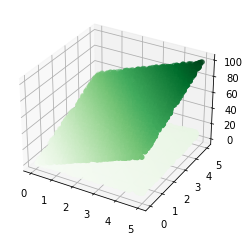

In [38]:
ax = plt.axes(projection='3d')
ax.scatter3D(X_train[:,0], X_train[:,1], y_train, c=y_train, cmap='Greens');

## Model

In [39]:
class FeedForward(nn.Module):
    def __init__(self, emb_dims, n_cont_feats, linear_layer_sizes, output_size, emb_dropout, hidden_dropouts):
        super(FeedForward, self).__init__()

        self.emb_layers = nn.ModuleList([nn.Embedding(x,y) for x, y in emb_dims])
        n_of_embs = sum([y for x, y in emb_dims])
        self.n_of_embs = n_of_embs
        self.n_cont_feats = n_cont_feats

        first_lin_layer = nn.Linear(self.n_of_embs + self.n_cont_feats, linear_layer_sizes[0])
        self.lin_layers = nn.ModuleList([first_lin_layer] + [nn.Linear(linear_layer_sizes[i], linear_layer_sizes[i+1]) for i in range(len(linear_layer_sizes) - 1)])

        # This may be unnecessary, I think layers are initialized this way to start with.
        # Can comment out and see if training performs the same.
        for lin_layer in self.lin_layers:
            nn.init.kaiming_normal_(lin_layer.weight.data)

        self.output_layer = nn.Linear(linear_layer_sizes[-1], output_size)
        nn.init.kaiming_normal_(self.output_layer.weight.data)

        self.first_bn_layer = nn.BatchNorm1d(self.n_cont_feats)
        self.bn_layers = nn.ModuleList([nn.BatchNorm1d(size) for size in linear_layer_sizes])

        self.emb_dropout_layer = nn.Dropout(emb_dropout)
        self.dropout_layers = nn.ModuleList([nn.Dropout(p) for p in hidden_dropouts])

    def forward(self, cont_data, cat_data):
        if self.n_of_embs != 0:
            x = [emb_layer(cat_data[:, i].long()) for i, emb_layer in enumerate(self.emb_layers)]
            x = torch.cat(x, 1)
            x = self.emb_dropout_layer(x)

        if self.n_cont_feats != 0:
            normalized_cont_data = self.first_bn_layer(cont_data)

        if self.n_of_embs != 0:
            x = torch.cat([x, normalized_cont_data], 1)
        else:
            x = normalized_cont_data
        
        for lin_layer, dropout_layer, bn_layer in zip(self.lin_layers, self.dropout_layers, self.bn_layers):
            x = F.relu(lin_layer(x))
            x = bn_layer(x)
            x = dropout_layer(x)

        x = self.output_layer(x)
        return x

        

In [42]:
cat_dims = [2]
emb_dims = [(x, min(50, (x + 1) // 2)) for x in cat_dims]


In [44]:
model = FeedForward(emb_dims=emb_dims, n_cont_feats=2, linear_layer_sizes=[50,100], output_size=1, emb_dropout=0.04, hidden_dropouts=[0.001, 0.01])

n_epochs = 100
loss_values = []
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

for epoch in range(n_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        cont_x = inputs[:,:2].float()
        cat_x = inputs[:,2:].float()

        preds = model(cont_x, cat_x)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch}/{n_epochs}, Loss: {loss.item():.3f}")
    loss_values.append(loss.item())

Epoch 0/100, Loss: 1060.055
Epoch 1/100, Loss: 1798.769
Epoch 2/100, Loss: 1739.708
Epoch 3/100, Loss: 2170.398
Epoch 4/100, Loss: 694.259
Epoch 5/100, Loss: 1718.315
Epoch 6/100, Loss: 1668.740
Epoch 7/100, Loss: 1219.368
Epoch 8/100, Loss: 1242.372
Epoch 9/100, Loss: 1027.333
Epoch 10/100, Loss: 910.337
Epoch 11/100, Loss: 711.371
Epoch 12/100, Loss: 2861.037
Epoch 13/100, Loss: 1412.157
Epoch 14/100, Loss: 1675.288
Epoch 15/100, Loss: 1880.741
Epoch 16/100, Loss: 1878.526
Epoch 17/100, Loss: 1664.503
Epoch 18/100, Loss: 1722.566
Epoch 19/100, Loss: 1505.195
Epoch 20/100, Loss: 1316.543
Epoch 21/100, Loss: 1180.048
Epoch 22/100, Loss: 1306.037
Epoch 23/100, Loss: 1359.906
Epoch 24/100, Loss: 1930.463
Epoch 25/100, Loss: 1857.199
Epoch 26/100, Loss: 1386.396
Epoch 27/100, Loss: 448.875
Epoch 28/100, Loss: 2095.215
Epoch 29/100, Loss: 1692.599
Epoch 30/100, Loss: 1467.892
Epoch 31/100, Loss: 908.791
Epoch 32/100, Loss: 1341.703
Epoch 33/100, Loss: 1526.123
Epoch 34/100, Loss: 895.671
E

KeyboardInterrupt: 

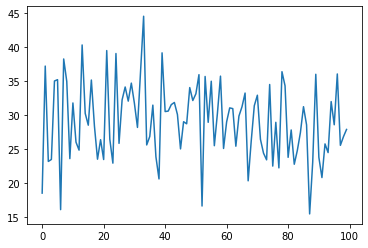

In [20]:
plt.plot(np.array(np.arange(0, n_epochs)), loss_values)
